# Taller #1: 💸 Automatiza tu presupuesto básico con IA (en 5 minutos)

Bienvenido/a a este mini taller interactivo ⚡️

En esta guía express vas a aprender cómo crear un presupuesto personal básico **de forma automática** usando Python, la librería LangChain y un poco de IA 🤖

> Ideal si quieres empezar a automatizar tareas repetitivas y ahorrar tiempo.

✅ Sin instalaciones complicadas
✅ Código 100% editable y reutilizable
✅ Te lo llevás funcionando en menos de 10 minutos

---

**¿Listo/a para empezar? Dale a “Runtime > Run all” y seguí los pasos paso a paso 👇**


## 🛠️ Paso 1: Instalación y setup base


In [ ]:
# Instalamos las librerías necesarias para este mini taller
# ✅ langchain: para manejar los pasos con IA
# ✅ langchain-google-genai y google-generativeai: para usar modelos de Google (Gemini)
# ✅ pandas: si querés mostrar o exportar presupuestos en tabla

!pip install langchain langchain-google-genai google-generativeai pandas -q


### ✅ Cómo usar API Secrets en Google Colab


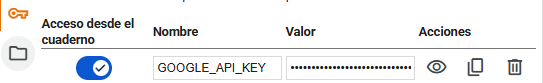

In [ ]:
# En esta celda vamos a recuperar tu API Key de Google desde los secretos del entorno
# Para eso, primero tenés que haberla guardado como 'GOOGLE_API_KEY' en Colab > Secrets
# Si no sabés cómo hacerlo, revisá la imagen de referencia que te dejamos arriba 📸

from google.colab import userdata
import google.generativeai as genai

api_key = userdata.get("GOOGLE_API_KEY")  # 🔐 Asegurate que esté seteada antes de continuar

## Paso 2: Convertir la idea del cliente en un resumen técnico

En este paso, vamos a usar un agente que toma una descripción simple de un cliente (en lenguaje natural) y genera un resumen estructurado del proyecto.

### 📈 Objetivo:

Convertir algo como:

> "Quiero una app para reservar canchas de fútbol y pagar online."

En:

* Objetivo del proyecto
* Funcionalidades clave
* Plataformas sugeridas
* Usuario final


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import Runnable
from pydantic import BaseModel, Field

In [ ]:
# Aca usamos un modelo pydantic por que le diremos al LLM como queremos que nos estructure la salida con descripciones de los campos
class Proyecto(BaseModel):
    titulo: str = Field(..., description="Título del proyecto")
    objetivo: str = Field(..., description="Objetivo general del proyecto")
    funcionalidades: list[str] = Field(..., description="Lista de funcionalidades clave")
    publico_objetivo: str = Field(..., description="Público objetivo del proyecto")
    plataformas: list[str] = Field(..., description="Plataformas sugeridas")
    perfiles_equipo: list[str] = Field(..., description="Perfiles técnicos mínimos requeridos")
    salarios_estimados: dict = Field(..., description="Salario diario estimado por perfil en USD (mercado latam)")

In [ ]:
# Parser para usar con LangChain
parser_proyecto = PydanticOutputParser(pydantic_object=Proyecto)

# Prompt template que incluye instrucciones para la salida y como pensar la respuesta
template_proyecto = PromptTemplate(
    template="""
    Eres un analista de software para una empresa reconocida en LatinoAmerica.
    A partir de esta descripción la petición de un cliente, devuelve en formato estructurado en proyecto de software funcional y ejecutable
    y con un costo realista por profesional (maximo 100 usd al día)

    {format_instructions}

    Petición del cliente:
    {peticion}
    """,
    input_variables=["peticion"],
    partial_variables={"format_instructions": parser_proyecto.get_format_instructions()}
)

In [ ]:
# Instanciar el modelo LLM
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=api_key)

# Construir la cadena
chain_proyecto: Runnable = template_proyecto | llm | parser_proyecto

### Ejemplo de la APP:

In [ ]:
# Input de ejemplo
peticion = "Quiero una app para alquilar canchas de fútbol con pagos online."
proyecto = chain_proyecto.invoke({"peticion": peticion})

# Mostrar resultado
print(proyecto.model_dump_json(indent=2))

{
  "titulo": "Plataforma Web para Alquiler de Canchas de Fútbol",
  "objetivo": "Desarrollar una plataforma web intuitiva y eficiente que permita a los usuarios reservar canchas de fútbol en línea, gestionar sus reservas y realizar pagos de forma segura, facilitando la conexión entre propietarios de canchas y jugadores.",
  "funcionalidades": [
    "Registro e inicio de sesión de usuarios.",
    "Búsqueda de canchas por ubicación, fecha, hora y tipo (fútbol 5, 7, 11, etc.).",
    "Visualización de información detallada de cada cancha (fotos, descripción, servicios, precios).",
    "Calendario de disponibilidad de canchas.",
    "Proceso de reserva y confirmación de reservas.",
    "Integración con pasarelas de pago online (Stripe, PayPal, Mercado Pago).",
    "Gestión de reservas por parte del usuario (cancelación, modificación).",
    "Sistema de notificaciones (recordatorios de reserva, confirmaciones de pago).",
    "Panel de administración para propietarios de canchas (gestión de 

Este paso transforma una idea en una base para estimar tiempos, costos y tecnologías ✔️


## Paso 3: Generar etapas, tecnologías y cronograma

In [ ]:
from typing import List

class Etapa(BaseModel):
    nombre: str = Field(..., description="Nombre claro de la etapa del proyecto (ej. 'Desarrollo Backend')")
    duracion_dias: int = Field(..., description="Duración estimada de esta etapa, en días calendario")
    costo_diario_estimado: int = Field(..., description="Costo diario estimado en USD para ejecutar esta etapa (considerando equipo y recursos)")
    justificacion_del_costo: str = Field(..., description="Justificar brevemente por que el precio por día")
    descripcion: str = Field(..., description="Descripción breve de lo que se hace en esta etapa en menos de 100 caracteres")

class PlanTecnico(BaseModel):
    etapas: List[Etapa] = Field(..., description="Lista de etapas del proyecto, cada una con duración, costo diario y descripción")
    tecnologias: List[str] = Field(..., description="Stack tecnológico sugerido para cumplir con los requerimientos del proyecto")


parser_tecnico = PydanticOutputParser(pydantic_object=PlanTecnico)

In [ ]:
template_tecnico = PromptTemplate(
    template="""
    Eres un project manager. A partir del siguiente resumen técnico del proyecto, genera:
    - Una lista de etapas con su nombre y duración en días
    - Un stack tecnológico sugerido (frameworks, lenguajes, servicios)
    - Costo diario del proyecto estimado en USD
    - Descripción de cada etapa

    Se realista con los presupuestos diarios y el stack tecnológico sugerido.
    limita el presupuesto diario a 300 usd por día y un maximo de 2 semanas (10 días) por funcionalidad o etapa.

    {format_instructions}

    Proyecto:
    Objetivo: {objetivo}
    Funcionalidades: {funcionalidades}
    Público objetivo: {publico_objetivo}
    Plataformas: {plataformas}
    Perfiles de equipo: {perfiles_equipo}
    Salarios estimados (diario en dolares): {salarios_estimados}
    """,
    input_variables=["objetivo", "funcionalidades", "publico_objetivo", "plataformas", "perfiles_equipo", "salario_estimado"],
    partial_variables={"format_instructions": parser_tecnico.get_format_instructions()}
)


In [ ]:
chain_tecnico: Runnable = template_tecnico | llm | parser_tecnico

In [ ]:
plan = chain_tecnico.invoke(proyecto.model_dump())
print("\n--- Paso 2: Plan Técnico Generado ---")
print(plan.model_dump_json(indent=2))


--- Paso 2: Plan Técnico Generado ---
{
  "etapas": [
    {
      "nombre": "Planificación y Diseño UX/UI",
      "duracion_dias": 10,
      "costo_diario_estimado": 230,
      "justificacion_del_costo": "PM, Diseñador UX/UI trabajando en conjunto. Costo incluye herramientas de diseño.",
      "descripcion": "Definición de la arquitectura y diseño de la interfaz de usuario."
    },
    {
      "nombre": "Desarrollo Front-end",
      "duracion_dias": 10,
      "costo_diario_estimado": 150,
      "justificacion_del_costo": "Desarrollador Front-end, PM supervisando. Incluye licencias de bibliotecas.",
      "descripcion": "Implementación de la interfaz de usuario y la lógica del cliente."
    },
    {
      "nombre": "Desarrollo Back-end y API",
      "duracion_dias": 10,
      "costo_diario_estimado": 175,
      "justificacion_del_costo": "Desarrollador Back-end, PM supervisando. Incluye costos de hosting básico.",
      "descripcion": "Implementación de la lógica del servidor y la API.

## Bonus: Crear un PDF

In [ ]:
!pip install fpdf -q

In [ ]:
from fpdf import FPDF

def exportar_proyecto_a_pdf(proyecto, plan, path_pdf="Plan_Proyecto.pdf"):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)

    # Paleta de colores suaves
    azul = (40, 65, 115)
    celeste = (220, 230, 241)
    celeste_tabla = (230, 240, 255)

    # Título principal
    pdf.set_font("Arial", "B", 18)
    pdf.set_text_color(*azul)
    pdf.cell(0, 14, proyecto.titulo, ln=True, align="C")
    pdf.ln(6)

    # Objetivo General
    pdf.set_font("Arial", "B", 13)
    pdf.set_fill_color(*celeste)
    pdf.set_text_color(0)
    pdf.cell(0, 10, "Objetivo General:", ln=True, fill=True)
    pdf.set_font("Arial", "", 12)
    pdf.multi_cell(0, 8, proyecto.objetivo)
    pdf.ln(2)

    # Funcionalidades clave
    pdf.set_font("Arial", "B", 13)
    pdf.cell(0, 10, "Funcionalidades clave:", ln=True, fill=True)
    pdf.set_font("Arial", "", 12)
    for f in proyecto.funcionalidades:
        pdf.set_text_color(*azul)
        pdf.cell(8, 8, "-", 0, 0)
        pdf.set_text_color(0)
        pdf.cell(0, 8, f, ln=True)
    pdf.ln(2)

    # Público objetivo
    pdf.set_font("Arial", "B", 13)
    pdf.cell(0, 10, "Público objetivo:", ln=True, fill=True)
    pdf.set_font("Arial", "", 12)
    pdf.multi_cell(0, 8, proyecto.publico_objetivo)
    pdf.ln(2)

    # Plataformas
    pdf.set_font("Arial", "B", 13)
    pdf.cell(0, 10, "Plataformas:", ln=True, fill=True)
    pdf.set_font("Arial", "", 12)
    pdf.multi_cell(0, 8, ", ".join(proyecto.plataformas))
    pdf.ln(2)

    # Equipo y salarios
    pdf.set_font("Arial", "B", 13)
    pdf.cell(0, 10, "Equipo y salarios estimados:", ln=True, fill=True)
    pdf.set_font("Arial", "", 12)
    for p in proyecto.perfiles_equipo:
        salario = proyecto.salarios_estimados.get(p, "-")
        pdf.cell(0, 8, f"{p}: USD {salario}/día", ln=True)
    pdf.ln(2)

    # Stack tecnológico
    pdf.set_font("Arial", "B", 13)
    pdf.cell(0, 10, "Stack tecnológico sugerido:", ln=True, fill=True)
    pdf.set_font("Arial", "", 12)
    pdf.multi_cell(0, 8, ", ".join(plan.tecnologias))
    pdf.ln(2)

    # Etapas del proyecto (tabla simple y color alterno)
    pdf.set_font("Arial", "B", 13)
    pdf.cell(0, 10, "Etapas del Proyecto y Presupuesto:", ln=True, fill=True)
    pdf.set_font("Arial", "B", 11)
    pdf.set_fill_color(*celeste_tabla)
    pdf.cell(58, 8, "Etapa", 1, 0, 'C', fill=True)
    pdf.cell(20, 8, "Días", 1, 0, 'C', fill=True)
    pdf.cell(30, 8, "Costo/día", 1, 0, 'C', fill=True)
    pdf.cell(32, 8, "Total etapa", 1, 1, 'C', fill=True)

    pdf.set_font("Arial", "", 10)
    total = 0
    for i, etapa in enumerate(plan.etapas):
        total_etapa = etapa.duracion_dias * etapa.costo_diario_estimado
        total += total_etapa
        fill = i % 2 == 0
        pdf.set_fill_color(*celeste_tabla) if fill else pdf.set_fill_color(255,255,255)
        pdf.cell(58, 8, etapa.nombre[:27], 1, 0, '', fill)
        pdf.cell(20, 8, str(etapa.duracion_dias), 1, 0, 'C', fill)
        pdf.cell(30, 8, f"${etapa.costo_diario_estimado}", 1, 0, 'R', fill)
        pdf.cell(32, 8, f"${total_etapa}", 1, 1, 'R', fill)
        pdf.set_font("Arial", "I", 9)
        pdf.cell(140, 7, etapa.descripcion[:100], 1, 1, '', fill)
        pdf.set_font("Arial", "", 10)

    pdf.set_font("Arial", "B", 12)
    pdf.set_fill_color(*celeste)
    pdf.cell(108, 10, "TOTAL PROYECTO", 1, 0, 'R', fill=True)
    pdf.cell(32, 10, f"${total}", 1, 1, 'R', fill=True)
    pdf.ln(10)

    # Guardar PDF
    pdf.output(path_pdf)


In [ ]:
exportar_proyecto_a_pdf(proyecto, plan, f"{proyecto.titulo}.pdf")
